# Actividad 4. Dirección de giro, señales de alto, autos, personas y semáforos en un video

## Documentación

- Esta actividad realícela en un nuevo notebook
- Defina las funciones necesarias para detectar autos, personas, altos y semáforos. Para cada uno agregue su
respectiva etiqueta.
- Utilice la función time.sleep(3) para que cuando se detecte en un área cercana al observador la señal de alto, se
realice una pausa de 3 segundos en el video (solo una vez).
- Defina las funciones y el proceso necesario para identificar la dirección del giro. No es necesario mostrar el video
de la imagen binarizada y de interés.
- Agregar también la flecha indicando la dirección de giro, así como su etiqueta.
- Utilice el video llamado carretera_altos_peatones_automoviles_semaforos.mp4
- Agregue al final de su notebook una explicación detallada de como funciona su código y una conclusión del
ejercicio o puede explicarlo conforme avance en el notebook (con celdas definidas con Markdown)

## Librerias

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import time

## Variables globales

In [2]:
filePath = "videos/carretera_altos_peatones_automoviles.mp4"

In [73]:
#Poligono de área de interés

#ld = (35, 150)
#lu = (30, 238)
#ru = (450, 238)
#rd = (440, 150)

#pts1 = np.float32([ld, rd, lu, ru])

#x1 = (160, 150)
#x2 = (180, 40)
#x3 = (280, 40)
#x4 = (300, 150)

#Old values
x1 = (180, 40)
x2 = (280, 40)
x3 = (160, 150)
x4 = (300, 150)

pts_poligono_fix = np.array([x3, x1, x2, x4], np.int32)
pts_poligono_fix = pts_poligono_fix.reshape((-1, 1, 2))

pts_poligono = np.array([x1, x2, x3, x4], np.int32)
pts_poligono = pts_poligono.reshape((-1, 1, 2))

## Función para la detección del giro

In [3]:
def binarizacion(imagen):
    img = cv.cvtColor(imagen, cv.COLOR_BGR2RGB)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_gauss = cv.GaussianBlur(img_gray, (3, 3), 0)
    thr, img_thr = cv.threshold(img_gauss, 160, 255, cv.THRESH_BINARY)
    alto = img.shape[0]
    ancho = img.shape[1]
    ratio = 0.2
    img_r = cv.resize(img_thr, (480, 240), interpolation = cv.INTER_NEAREST)
    return(img_r)

In [6]:
def area_interes(imagen):
    pts1 = np.float32([x1, x2, x3, x4])
    pts2 = np.float32([[0, 0], [480, 0], [0, 240], [480, 240]])
    matrix = cv.getPerspectiveTransform(pts1, pts2)
    img_warp = cv.warpPerspective(imagen, matrix, (480, 240))
    return (img_warp)

In [61]:
def punto_medio(imagen):
    img_cercana= imagen[220:, :]
    suma_columnas = img_cercana.sum(axis=0)
    x_pos = np.arange(len(suma_columnas))
    try:
        mid_point=int( np.dot(x_pos,suma_columnas) / np.sum( suma_columnas ) )
        return mid_point
    except:
        print('no hay datos')
        return 'no hay datos'

In [56]:
#Funcion suma normalizada izquierda
def sum_izquierda(imagen, valor_punto_medio):
    if valor_punto_medio != 'no hay datos':
        return np.round(np.sum( imagen[:, :valor_punto_medio].sum(axis=0) )/(255*240*480),2)

In [62]:
#Funcion suma normalizada derecha
def sum_derecha(imagen, valor_punto_medio):
    if valor_punto_medio != 'no hay datos':
        return np.round(np.sum( imagen[:, valor_punto_medio:].sum(axis=0) )/(255*240*480),2)

In [57]:
def deteccion_direccion(imagen):
    img_bin = binarizacion(imagen) #binariza la imagen
    img_interes = area_interes(img_bin) #encuentra la zona de interes
    mid_point = punto_medio(img_interes) # encuentra el punto medio de la zona de interes
    
    #calculos de pixeles
    valor_sum_izquierda = sum_izquierda(img_interes, mid_point)
    valor_sum_derecha = sum_derecha(img_interes, mid_point)
    
    
    #cv.putText(img_interes, str(valor_sum_izquierda), org1, font, fontScale, color, thickness, cv.LINE_AA, False)
    #cv.putText(img_interes, str(valor_sum_derecha), org2, font, fontScale, color, thickness, cv.LINE_AA, False)
    try:
        delta = valor_sum_izquierda - valor_sum_derecha
    #print(delta)
    
        if delta > 0.07 :
            movimiento = "izquierda"

            
        elif delta < -0.07 :
            movimiento = "derecha"
            
        else:
            movimiento = "adelante"
            
    #cv.putText(img_interes, movimiento, org3, font, fontScale, color, thickness, cv.LINE_AA, False)
        return movimiento
    except:
        return 'No hay valores'

In [84]:
def flecha_print(image, direccion):
    
    start_point = (0, 0) 
    end_point = (200, 200)
    # Green color in BGR  
    color = (0, 255, 0)
    # Line thickness of 9 px  
    thickness = 20
    image = cv.arrowedLine(image, start_point, end_point, 
                                     color, thickness)
    if direccion == 'derecha':
        #imprime una flecha hacia la derecha jsjsjsjs
        start_point = (0, 0) 
        end_point = (200, 200)
        image = cv.arrowedLine(image, start_point, end_point, 
                                     color, thickness)
        return image
    elif direccion == 'izquierda':
        #imprime una flecha hacia la izquierda
        start_point = (0, 0) 
        end_point = (200, 200)
        image = cv.arrowedLine(image, start_point, end_point, 
                                     color, thickness)
        return image
    elif direccion == 'adelante':
        #imprime una flecha hacia adelante
        start_point = (0, 0) 
        end_point = (200, 200)
        image = cv.arrowedLine(image, start_point, end_point, 
                                     color, thickness)
        return image

## Función para la detección de altos, carros y peatones

In [21]:
#importando datos haar cascade
stop_cascade = cv.CascadeClassifier('datos/Stopsign_HAAR_19Stages.xml')
car_cascade = cv.CascadeClassifier('datos/cars.xml')
peaton_cascade = cv.CascadeClassifier('datos/haarcascade_fullbody.xml')


In [35]:
#definiendo funcion de deteccion
def video_detect(frame):
    
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    
    altos = stop_cascade.detectMultiScale(gray, 1.12, 5)
    autos = car_cascade.detectMultiScale(gray, 1.13, 5)
    peaton = peaton_cascade.detectMultiScale(gray, 1.11, 5)

    for (x, y, w, h) in autos:

        cv.rectangle(frame, (x, y), (x + w, y + h), (213,152,221), 2)
        cv.putText(frame, 'Carro', (x, y), 6, 0.8, (213,152,221), 2)

    for (x, y, w, h) in altos:

        cv.rectangle(frame, (x, y), (x + w, y + h), (76,163,221), 2)
        cv.putText(frame, 'Alto', (x, y), 6, 0.8, (76,163,221), 2)

    for (x, y, w, h) in peaton:

        cv.rectangle(frame, (x, y), (x + w, y + h), (13,236,175), 2)
        cv.putText(frame, 'Peaton', (x, y), 6, 0.8, (13,236,175), 2)


        fr_gray = gray[y:y + h, x:x + w]
        fr_color = frame[y:y + h, x:x + w]
        
    #return frame

## Función para la detección de semáforos

### Tratamiento de imagenes

In [23]:
def hsv_convert(image):
    return cv.cvtColor(image, cv.COLOR_BGR2HSV)

In [24]:
#definimos una función que retorne la mascara para el color verde
def green_finder(image):
    
    lower_green = np.array([34, 50, 232]) # 39, 50, 83
    upper_green = np.array([82, 255, 255])#91, 255, 255
    
    img_hsv = hsv_convert(image)
    mask_green = cv.inRange(img_hsv, lower_green, upper_green)
    
    return mask_green

In [25]:
#definimos una función que retorne la mascara para el color amarillo
def yellow_finder(image):
    
    lower_green = np.array([12, 43, 232])
    upper_green = np.array([53, 255, 255])

    img_hsv = hsv_convert(image)
    mask = cv.inRange(img_hsv, lower_green, upper_green)
    mask_green = mask
    
    return mask_green

In [26]:
#definimos una función que retorne la mascara para el color rojo
def red_finder(image):#
    lower_red1 = np.array([0,9,237])#0,65,100 older 0, 100, 100 
    upper_red1 = np.array([5,255,255]) #5,255,255
    lower_red2 = np.array([170,9,237]) #170,100,100
    upper_red2 = np.array([180,255,255]) #180,255,255
    
    img_hsv = hsv_convert(image)#
    
    mask1 = cv.inRange(img_hsv, lower_red1, upper_red1)
    mask2 = cv.inRange(img_hsv, lower_red2, upper_red2)
    
    mask_red = cv.add(mask1, mask2)
    
    return mask_red

### Circulos

In [27]:
def circle_finder(img):
    circles = cv.HoughCircles(img, cv.HOUGH_GRADIENT, 1, 30, param1 = 50, param2 = 5, minRadius = 0, maxRadius = 30)
    return circles

In [58]:
def print_circle(image, color_mask, label, gamma):
    
    #Estética de escritura
    font = cv.FONT_HERSHEY_SIMPLEX
    region = 5
    
    #Circulos
    circles = circle_finder(color_mask)

    #Entra si existe un circulo
    if circles is not None:
        
        circles = np.uint16(np.around(circles))
        print('In print_circle() color', label)
        
        #Para cada circulo
        for i in circles[0, :]:
            pixel_value = 0.0
            n = 0.0
            check = False
            
            for j in range(-region, region):
                for k in range(-region, region):
                    #print('region:', region)
                    #print('pixel_value:', pixel_value)
                    try:
                        pixel_value += color_mask[i[1]+j, i[0]+k]
                        
                    except:
                        print('In print_circle() data in bound')
                        
                    n += 1

            if pixel_value/n > gamma:
                print('In print_circle() passed gamma at:', pixel_value/n )
                cv.circle(image, (i[0], i[1]), i[2]+10, (0,255,0), 2)
                cv.putText(image, label, (i[0]-i[2], i[1]-i[2]-10), font, 1, (0, 255, 0), 2, cv.LINE_AA)
    
    return cv.cvtColor(image, cv.COLOR_BGR2RGB)

# Video

In [92]:
video = cv.VideoCapture(filePath)
count = 1
stopCheck = False

cv.startWindowThread()

# font 
font = cv.FONT_HERSHEY_SIMPLEX 
# org 
org = (50, 50) 
fontScale = 1
# azul 
color = (255, 0, 0) 
thickness = 2

while(video.isOpened()):
    
    ret, frame = video.read()
    alto = frame.shape[0]
    ancho = frame.shape[1]
    ratio = 0.8
    frame = cv.resize(frame, ( int(ancho*ratio) , int(alto*ratio) ), interpolation=cv.INTER_NEAREST )
    
    if ret:
        #PRINT numero de frame
        print('In frame:', count)
        
        print('deteccion_direccion(frame):', deteccion_direccion(frame))
        
        print 
        #deteccion de semadoro en VERDE
        green_mask = green_finder(frame)
        semaforo_verde = print_circle(frame, green_mask, 'Verde', 20)
        RGB_fix = cv.cvtColor(semaforo_verde, cv.COLOR_BGR2RGB)
        
        
        #deteccion de semadoro en ROJO
        red_mask = red_finder(frame)
        semaforo_rojo = print_circle(frame, red_mask, 'Rojo', 29)
        RGB_fix = cv.cvtColor(semaforo_rojo, cv.COLOR_BGR2RGB)
        
        
        #deteccion de semadoro en AMARILLO
        yellow_mask = yellow_finder(frame)
        semaforo_amarillo = print_circle(frame, yellow_mask, 'Amarillo', 20)
        RGB_fix = cv.cvtColor(semaforo_amarillo, cv.COLOR_BGR2RGB)
        
        #detección de personas/carros/altos
        video_detect(frame)
    
        #detección de altos con numero de frame en esquina
        #print('altos_check()', altos_check(frame))
        #Detiene 3 segundos el video si encuentra el alto
        #if stopCheck == False:
            #if altos_check(frame):
                #time.sleep(3)
                #stopCheck = True
            
        #altos_printer(frame)
        frame = cv.putText(frame, str(count), org, font, fontScale, color, thickness, cv.LINE_AA) 
        count +=1
        
        #flecha de direccion
        frame = cv.putText(frame, deteccion_direccion(frame), (200, 300), font, fontScale, color, thickness, cv.LINE_AA)
        
    
        cv.imshow("video", frame)
        
        
        #video binarizado
        img_bin = binarizacion(frame)
        cv.polylines(img_bin, [pts_poligono_fix], True, (100,100,100))
        cv.imshow("video binarizado", img_bin)
        
        #video zona de interes
        img_interes = area_interes(img_bin)
        mid_point = punto_medio(img_interes)
        cv.circle(img_interes, (mid_point, 235), 5, (100,100,100), -1) ;
        cv.imshow("video area interes", img_interes)
        
        
        time.sleep(0.002)
        
        if cv.waitKey(1) & 0xFF == ord('q'):
            print('q')
            break            

cv.waitKey(5000)
        
cv.waitKey(1)

cv.destroyAllWindows()

video.release()

cv.waitKey(1)

In frame: 1
deteccion_direccion(frame): adelante
In frame: 2
deteccion_direccion(frame): adelante
In frame: 3
deteccion_direccion(frame): adelante
In frame: 4
deteccion_direccion(frame): adelante
In frame: 5
deteccion_direccion(frame): adelante
In frame: 6
deteccion_direccion(frame): adelante
In frame: 7
deteccion_direccion(frame): adelante
In frame: 8
deteccion_direccion(frame): adelante
In frame: 9
deteccion_direccion(frame): adelante
In frame: 10
deteccion_direccion(frame): adelante
In frame: 11
deteccion_direccion(frame): adelante
In frame: 12
deteccion_direccion(frame): adelante
In frame: 13
deteccion_direccion(frame): adelante
In frame: 14
deteccion_direccion(frame): adelante
In frame: 15
deteccion_direccion(frame): adelante
In frame: 16
deteccion_direccion(frame): adelante
In frame: 17
deteccion_direccion(frame): adelante
In frame: 18
deteccion_direccion(frame): adelante
In frame: 19
deteccion_direccion(frame): adelante
In frame: 20
deteccion_direccion(frame): adelante
In frame:

In frame: 168
deteccion_direccion(frame): derecha
In frame: 169
deteccion_direccion(frame): derecha
In frame: 170
deteccion_direccion(frame): derecha
In frame: 171
deteccion_direccion(frame): derecha
In frame: 172
deteccion_direccion(frame): derecha
In frame: 173
deteccion_direccion(frame): derecha
In frame: 174
deteccion_direccion(frame): derecha
In frame: 175
deteccion_direccion(frame): derecha
In frame: 176
deteccion_direccion(frame): derecha
In frame: 177
deteccion_direccion(frame): derecha
In frame: 178
deteccion_direccion(frame): adelante
In frame: 179
deteccion_direccion(frame): adelante
In frame: 180
deteccion_direccion(frame): adelante
In frame: 181
deteccion_direccion(frame): adelante
In frame: 182
deteccion_direccion(frame): adelante
In frame: 183
deteccion_direccion(frame): adelante
In frame: 184
deteccion_direccion(frame): adelante
In frame: 185
deteccion_direccion(frame): adelante
In frame: 186
deteccion_direccion(frame): adelante
In frame: 187
deteccion_direccion(frame):

<ipython-input-61-c57670ecddaf>:6: RuntimeWarning: invalid value encountered in double_scalars
  mid_point=int( np.dot(x_pos,suma_columnas) / np.sum( suma_columnas ) )


no hay datos
In frame: 237
no hay datos
deteccion_direccion(frame): No hay valores
no hay datos
In frame: 238
no hay datos
deteccion_direccion(frame): No hay valores
no hay datos
In frame: 239
no hay datos
deteccion_direccion(frame): No hay valores
no hay datos
In frame: 240
no hay datos
deteccion_direccion(frame): No hay valores
no hay datos
In frame: 241
no hay datos
deteccion_direccion(frame): No hay valores
no hay datos
In frame: 242
no hay datos
deteccion_direccion(frame): No hay valores
no hay datos
In frame: 243
no hay datos
deteccion_direccion(frame): No hay valores
no hay datos
In frame: 244
no hay datos
deteccion_direccion(frame): No hay valores
no hay datos
In frame: 245
no hay datos
deteccion_direccion(frame): No hay valores
no hay datos
In frame: 246
no hay datos
deteccion_direccion(frame): No hay valores
no hay datos
In frame: 247
no hay datos
deteccion_direccion(frame): No hay valores
no hay datos
In frame: 248
no hay datos
deteccion_direccion(frame): No hay valores
no h

In frame: 377
deteccion_direccion(frame): adelante
In frame: 378
deteccion_direccion(frame): adelante
In frame: 379
deteccion_direccion(frame): adelante
In frame: 380
deteccion_direccion(frame): adelante
In frame: 381
deteccion_direccion(frame): izquierda
In frame: 382
deteccion_direccion(frame): izquierda
In frame: 383
deteccion_direccion(frame): izquierda
In frame: 384
deteccion_direccion(frame): izquierda
In frame: 385
deteccion_direccion(frame): izquierda
In frame: 386
deteccion_direccion(frame): adelante
In frame: 387
deteccion_direccion(frame): adelante
In frame: 388
deteccion_direccion(frame): adelante
In frame: 389
deteccion_direccion(frame): adelante
In frame: 390
deteccion_direccion(frame): adelante
In frame: 391
deteccion_direccion(frame): adelante
In frame: 392
deteccion_direccion(frame): adelante
In frame: 393
deteccion_direccion(frame): izquierda
In frame: 394
deteccion_direccion(frame): izquierda
In frame: 395
deteccion_direccion(frame): izquierda
In frame: 396
deteccion

no hay datos
In frame: 511
no hay datos
deteccion_direccion(frame): No hay valores
In print_circle() color Rojo
In print_circle() passed gamma at: 35.7
no hay datos
In frame: 512
no hay datos
deteccion_direccion(frame): No hay valores
In print_circle() color Rojo
In print_circle() passed gamma at: 33.15
no hay datos
In frame: 513
no hay datos
deteccion_direccion(frame): No hay valores
In print_circle() color Rojo
no hay datos
In frame: 514
no hay datos
deteccion_direccion(frame): No hay valores
In print_circle() color Rojo
no hay datos
In frame: 515
no hay datos
deteccion_direccion(frame): No hay valores
In print_circle() color Rojo
no hay datos
In frame: 516
no hay datos
deteccion_direccion(frame): No hay valores
In print_circle() color Rojo
no hay datos
In frame: 517
no hay datos
deteccion_direccion(frame): No hay valores
In print_circle() color Rojo
In print_circle() passed gamma at: 35.7
no hay datos
In frame: 518
no hay datos
deteccion_direccion(frame): No hay valores
In print_cir

no hay datos
In frame: 567
no hay datos
deteccion_direccion(frame): No hay valores
In print_circle() color Verde
no hay datos
In frame: 568
no hay datos
deteccion_direccion(frame): No hay valores
In print_circle() color Verde
In print_circle() passed gamma at: 22.95
no hay datos
In frame: 569
no hay datos
deteccion_direccion(frame): No hay valores
In print_circle() color Verde
no hay datos
In frame: 570
deteccion_direccion(frame): adelante
In print_circle() color Verde
In print_circle() passed gamma at: 35.7
In frame: 571
deteccion_direccion(frame): adelante
In print_circle() color Verde
In frame: 572
no hay datos
deteccion_direccion(frame): No hay valores
In print_circle() color Verde
In print_circle() passed gamma at: 43.35
no hay datos
In frame: 573
deteccion_direccion(frame): adelante
In print_circle() color Verde
In frame: 574
no hay datos
deteccion_direccion(frame): No hay valores
In print_circle() color Verde
no hay datos
In frame: 575
no hay datos
deteccion_direccion(frame): No

KeyboardInterrupt: 

# Analisis de imagenes

### Prueba para cambio de dirección

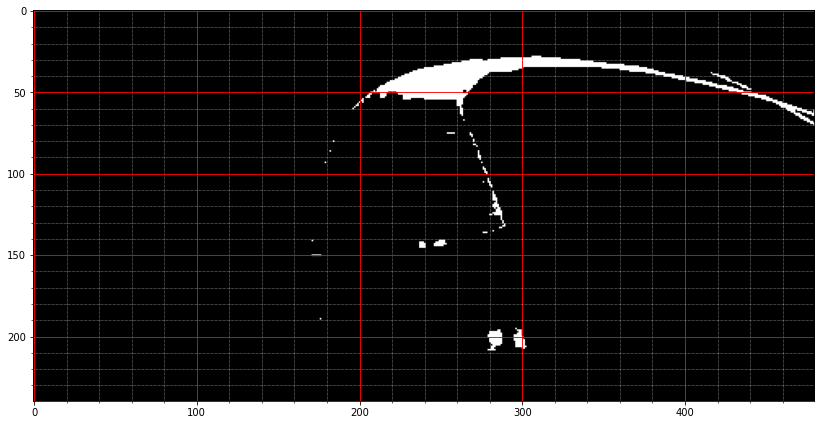

In [63]:
#probar la binarizacion en una imagen del video
img = cv.imread('figuras/imagen1_0.jpg')
img_bin = binarizacion(img)
fig, ax = plt.subplots(figsize = (14, 14))
ax.imshow(img_bin, cmap = 'gray')
ax.minorticks_on()
ax.grid(which = 'major', linestyle = '-', linewidth = '0.9', color = 'red')
ax.grid(which = 'minor', linestyle = ':', linewidth = '0.5', color = 'white')

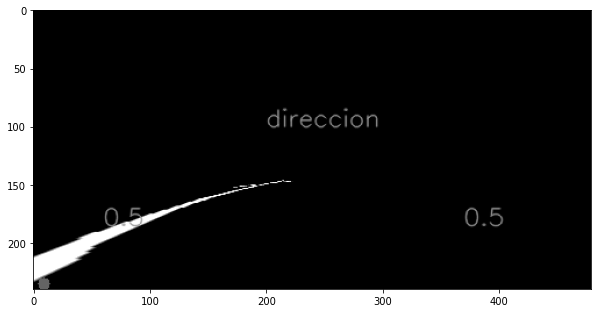

In [64]:
imagen = 'figuras/imagen1_0.jpg'

img = cv.imread(imagen)

img_bin = binarizacion(img)
img_interes = area_interes(img_bin)
mid_point = punto_medio(img_interes)

#textos
text1 = str(0.50)
text2 = str(0.50)
text3 = 'direccion'

#agregamos el tipo de fuente
font = cv.FONT_HERSHEY_SIMPLEX

#origen de cada texto
org1 = (60, 185)
org2 = (370, 185)
org3 = (200, 100)

#tamaño 
fontScale = 0.7

#color de la fuente
color = (150, 150, 150)

#grosor
thickness = 1

#usamos la funcion 'cv.putText()' que permitirá agregar texto
cv.putText(img_interes, text1, org1, font, fontScale,
              color, thickness, cv.LINE_AA, False)
cv.putText(img_interes, text2, org2, font, fontScale,
              color, thickness, cv.LINE_AA, False)
cv.putText(img_interes, text3, org3, font, fontScale,
              color, thickness, cv.LINE_AA, False)

plt.figure(figsize = (10, 7))
cv.circle(img_interes, (mid_point, 235), 5, (100, 100, 100), -1);
plt.imshow(img_interes, cmap = 'gray')
plt.show()

# Recopilación de imágenes

In [38]:
#Captura todas las frames del video
vidcap = cv.VideoCapture(filePath)
success,image = vidcap.read()
count = 0
while success:
    cv.imwrite("all_frames_act3/stop_test_frame%d.jpg" % count, image)     # save frame as JPEG file      
    success,image = vidcap.read()
    print('Read a new frame: ', success)
    count +=1


Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame